# Validator Rewards in Practice
In the [previous article](https://pintail.xyz/posts/beacon-chain-validator-rewards/) we looked at the rewards and penalties validators receive for participating in the beacon chain's consensus process and assembled a model to estimate expected net rewards, based on network participation rate and validator uptime. This time we're going to look at data from mainnet to see how it compares. We'll be using [Jim McDonald](https://twitter.com/jgm)'s invaluable [chaind](https://github.com/wealdtech/chaind) tool to index the beacon chain to do this. We'll be focusing on data the first 32,000 epochs (around 4½ months) so that for now we can disregard the impact of the [block production incident](https://medium.com/prysmatic-labs/eth2-mainnet-incident-retrospective-f0338814340c), which occurred in late April 2021.

# Modelling Average Net Reward

Let's start by looking at aggregate data from the network. By aggregating all this data across more than 120,000 validators, we will get a view of the *average* rewards/penalties received by validators. This is allows us to pick up where we left off last time, since all the values calculated by our model in the previous article were *expected* (i.e. average) values, so we should get a good sense of how well the model fits the observed network performance. After that we can go a bit deeper into the individual reward/penalty componenets, and individual validators. This can give us an idea precisely which types of issue are leading to performance which falls short of the ideal.

Recall that our model for expected net rewards was given by:
$$
R = 3BPU - 3B(1-U) + \frac{7}{8}BPU\frac{\ln(P)}{P-1} + \frac{1}{8}BPU
$$
However, since we're modelling the whole network in aggregate, we will assume that each individual validator's uptime $U$ is equal to the overall network participation rate $P$ which gives us:
$$
R = 3BP^2 - 3B(1-P) + \frac{7}{8}BP^2\frac{\ln(P)}{P-1} + \frac{1}{8}BP^2
$$

Our model therefore has only two parameters — the participation rate $P$, and the the base reward $B$, which is in turn a function of the the total active stake. For simplicity's sake, let's assume that the participation rate $P$ is constant for the period being considered, and use the average observed value from the network. For each epoch, this is given by the sum of the *attesting balance* — the combined effective balance of all validators whose attestations were included — divided by the total *active balance* — the combined effective balance of all active validators.

In [1]:
# imports, constants, db connection

import time
import math
import statistics
import csv
from datetime import datetime
from datetime import timedelta

import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from utils import strprogress

FAR_FUTURE_EPOCH = 2**64 - 1 # as defined in spec
END_EPOCH = 32000

# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [2]:
# find average participation rate

cursor.execute(f"SELECT f_active_balance, f_attesting_balance FROM t_epoch_summaries "
               f"WHERE f_epoch < {END_EPOCH} ORDER BY f_epoch")
active_balance, attesting_balance = list(zip(*cursor.fetchall()))

p_rate = [attesting_balance[i] / active_balance[i] for i in range(len(active_balance))]
average_p_rate = sum(p_rate)/len(p_rate)

print(f"average participation rate: {100*average_p_rate:.1f}%")

average participation rate: 99.0%


As calculated above, the average participation rate across the first 32,000 epochs is 99%. Armed with this figure, we can model the expected reward, based on the amount of Ether staked by active validators each epoch.

# Actual Average Rewards

To make a comparison we also need to calculate what the *actual* average reward was. We can do this by looking at how the balances of the active validators changed, as recorded by chaind. There are a few adjustments we need to make to the aggregate figures to accurately reflect mainnet rewards and penalties:

1. We exclude eth1 deposits erroneously made by some users to active validators;
2. We exclude slashed validators, since slashing penalties are relatively large, but are only incurred when multiple instances of the same validator are run simultaneously or for provably malicious actions;
3. We exclude validators who slash others, since the large rewards received by these validators also distort the overall picture of rewards.

What proportion validators are we excluding from our analysis by removing the slashed and slashers? We can calculate a quick and dirty upper-bound on this figure by looking at the number of validators we are excluding from the set (the number of slashed validators plus the validators who did the slashing) and dividing by minimimum number of active validators — i.e. number of the genesis validators.

In [3]:
# calculate upper bound on percentage of excluded validators

cursor.execute("SELECT COUNT(*) FROM t_validators WHERE f_slashed")
n_to_remove = 2 * cursor.fetchone()[0]

print(f"number of slashed/slasher validators: {n_to_remove}")

cursor.execute("SELECT COUNT(*) FROM t_validators WHERE f_activation_epoch = 0")
n_genesis = cursor.fetchone()[0]

print(f"minimum number of active validators: {n_genesis}")
print(f"upper-bound percentage of validators excluded from average: {100 * n_to_remove / n_genesis:.1f}%")

number of slashed/slasher validators: 268
minimum number of active validators: 21063
upper-bound percentage of validators excluded from average: 1.3%


As the calculation above shows, at worst we are excluding 1.3% of the validator set from our analysis. We expect therefore that our calculations of average net reward will not be significantly affected. The [code used](epoch_extras.py) to calculate the average rewards and store the relevant data in the chaind database was run prior to this notebook.

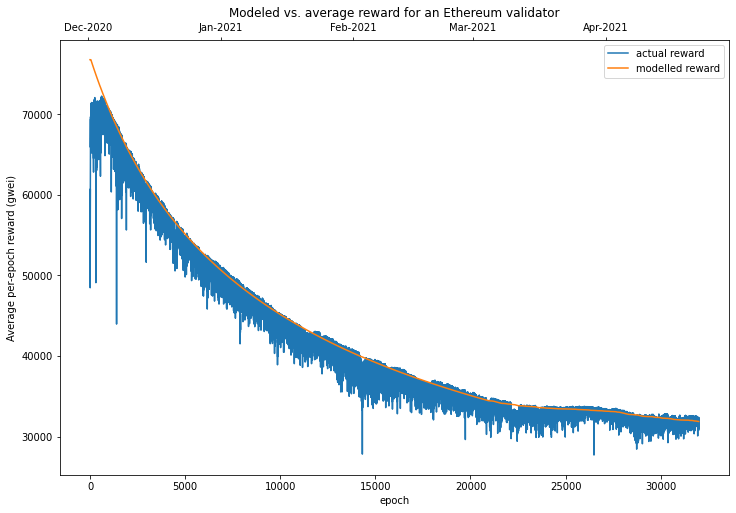

In [4]:
# calculate and plot modelled and average rewards

def base_reward(active_balance, effective_balance=int(32e9)):
    return effective_balance * 64 // math.isqrt(active_balance) // 4

cursor.execute(f"SELECT * FROM t_epoch_extras WHERE f_epoch < {END_EPOCH} ORDER BY f_epoch")
_, aggregate_reward, aggregate_reward_nonslashed, active_balance_nonslashed = list(zip(*cursor.fetchall()))

average_reward_nonslashed = []
modelled_reward = []
for e in range(END_EPOCH):
    # look at the average reward received by a supposed 32 ETH validator
    # (almost all validators have a 32 ETH effective balance)
    average_reward_nonslashed.append(32e9 * aggregate_reward_nonslashed[e] / active_balance_nonslashed[e])
    
    p = average_p_rate
    b = base_reward(active_balance[e])
    modelled_reward.append(3*b*p**2-3*b*(1-p)+(7/8)*b*p**2*math.log(p)/(p-1)+(1/8)*b*p**2)

rewards = pd.DataFrame({
    "average_reward_nonslashed": average_reward_nonslashed,
    "modelled_reward":modelled_reward
})

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
ax1.plot(range(END_EPOCH), average_reward_nonslashed, label="actual reward")
ax1.plot(range(END_EPOCH), modelled_reward, label="modelled reward")
ax1.legend()
ax2.plot([datetime(2020,12,1,12,0,23), datetime(2021,4,22,17,13,59)], [0,0], linestyle="None")

ax2.set_title('Modeled vs. average reward for an Ethereum validator')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Average per-epoch reward (gwei)')
ax2.xaxis.tick_top()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_visible(False);

As shown in the chart above, our simple model seems to be a fairly good fit for the data, but overall it seems to predict slightly higher rewards than were actually the case. Let's calculate just how much this premium was:

In [5]:
# calculate model premium

premium = [modelled_reward[i] / a - 1 for i, a in enumerate(average_reward_nonslashed)]
average_premium = sum(premium) / len(premium)

print(f"on average, the model predicted {100 * average_premium:.2}% "
      f"higher rewards than were observed in practice")

on average, the model predicted 1.7% higher rewards than were observed in practice


So, at a 1.7% overestimate for average rewards, our model captured the vast majority of the variability in average per-epoch rewards. The slight overestimate however seems to be fairly consistent across the dataset. To understand where this discrepancy comes from, let's take a look at an individual validator performance.

# Validator Performance

As explained in the previous article, the actual rewards available to any given validator depend to some degree on luck. In particular the number of proposer duties assigned to each validator can vary significantly. To a lesser extent, validators can also lose out when skipped slots lead to their attestations being delayed — through no fault of the attesting validator.

If we want to compare validators' performance then, we need to look at what each validator makes of the opportunities it is given. One way of doing this is looking at what level of reward would have been available to the validator, had it performed its duties perfectly (after accounting for deficiencies in the performance of the rest of the network). This is the *maximum cumulative reward* across the period. We will then compare this with the *actual net reward* that validator earned over the period. This is the sum of all earned rewards less any penalties incurred for imperfect attestation.

The ratio of *actual* to *maximum* rewards is then defined as *validator efficiency*. In other words, what proportion of the available rewards were captured by a given validator. We can then use validator efficiency as a metric to compare between validators, and produce a ranking which places the optimally functioning validators at the top.

Validator rewards come in two parts — rewards for block proposal, which are occasional and occur randomly, and rewards for attestation, which are available every epoch (6.4 minutes). Let's start by looking at performance on attestations.

## Attestation Efficiency

In our model, we assumed that validators performed their attestation duties either perfectly or not at all. However, as the data above showed, this led us to a small over-estimate of actual rewards. The reason for this is that it is possible for a validator to fulfill its attestation duties, but without receiving the full reward. To understand how this can happen, we need to look a little more closely at what validators are actually rewarded *for*. As mentioned in the previous article, attestations can be rewarded with up to one `base_reward` for each of four things:
1. **Correct source vote**. An attestation contains a vote for the checkpoint block serving as the "source" for the CasperFFG finality overlay. In practice an attestation can only be included if the source vote is correct, so the source vote reward could equivalently be treated as an "inclusion reward".
2. **Correct target vote**. An vote for the checkpoint block serving as the "target" for the CapserFFG finality overlay.
3. **Correct head vote**. A vote for the current block at the head of the chain.
4. **Inclusion delay**. A final `base_reward` is split between the attester and block proposer. The attester receives a maximum of $\frac{7}{8}$ `base_reward`, scaled inversely by the number of slots of delay to inclusion. The block proposer receives $\frac{1}{8}$ `base_reward` for each attestation they include.

*NB for full details of the meaning and function of "source", "target" and "head" votes, see the [Gasper paper](https://arxiv.org/pdf/2003.03052.pdf).*

The proportion of validators receiving reward (1) is already described fully by the participation rate. If validators don't submit the correct source vote, their attestations won't be included at all, and in effect this means the validator does not participate. Rewards (2) and (3) are slightly different — validators vote for the block that appears to them to be the 'correct' target or head block, but some validators may have an incomplete or delayed view of the blockchain, leading them to vote for a block which is different to the one ultimately finalised for that slot. In such cases, validators which voted for the 'correct' block receive a partial `base_reward`, scaled in proportion with the proportion of the active stake which voted the same way. Validators who vote for an 'incorrect' block will penalised one whole `base_reward`.

We've talked about (4), the inclusion delay reward, before — but our model assumed that 'online' validators would only have their attestations delayed if the earliest inclusion slot had no block. In practice, attestations may be delayed by other factors too — network latency could mean that the block proposer does not receive the attestation in time for inclusion into the earliest block, for example.

For a sense of what this data tells us, let's have a look in detail at the performance of a single validator. We'll start by focusing on a validator from the genesis validator set, [validator 1111](https://beaconcha.in/validator/1111). As usual, we'll be working from the [chaind](https://github.com/wealdtech/chaind) database, but some additional per-validator performance statistics have been compiled using a separate [Python script](validator_epoch_extras.py) and [supporting module](chaind_extras.py).

max reward: 1.3370 ETH
actual reward: 1.3116 ETH
attestation efficiency = 98.1%
shortfall 0.0254 ETH
...due to missed attestations: 0.0147 ETH (57.8%)
...due to incorrect head:      0.0082 ETH (32.3%)
...due to incorrect target:    0.0023 ETH (9.1%)
...due to excess delay:        0.0002 ETH (0.8%)




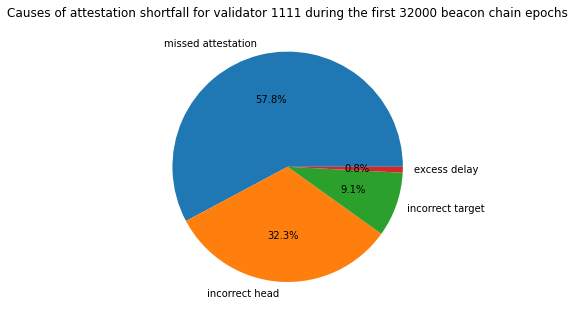

In [6]:
# get attestation efficiency for validator 1111

cursor.execute(
    f"SELECT * FROM t_validator_epoch_extras WHERE f_validator_index = 1111 AND f_epoch = {END_EPOCH}"
)
_, _, _, reward, max_reward, missed, target, head, delay, _, _ = cursor.fetchone()

print(f"max reward: {max_reward/1e9:.4f} ETH")
print(f"actual reward: {reward/1e9:.4f} ETH")
print(f"attestation efficiency = {100*reward/max_reward:.1f}%")
shortfall = max_reward - reward
print(f"shortfall {shortfall/1e9:.4f} ETH")
print(f"...due to missed attestations: {missed/1e9:.4f} ETH ({100*missed/shortfall:.1f}%)")
print(f"...due to incorrect head:      {head/1e9:.4f} ETH ({100*head/shortfall:.1f}%)")
print(f"...due to incorrect target:    {target/1e9:.4f} ETH ({100*target/shortfall:.1f}%)")
print(f"...due to excess delay:        {delay/1e9:.4f} ETH ({100*delay/shortfall:.1f}%)\n\n")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(
    [missed, head, target, delay],
    labels=['missed attestation', 'incorrect head', 'incorrect target', 'excess delay'],
    autopct='%1.1f%%'
)
ax.set_title(
    f'Causes of attestation shortfall for validator 1111 during the first {END_EPOCH} beacon chain epochs'
)
plt.show()

So, for the first 32000 epochs, validator 1111 had an attestation efficiency of 98%, meaning that it received 98% of the maximum possible attestation rewards available to it. By taking account of both the opportunity cost and penalties for missed or incorrect attestations, we can break down the shortfall into its component causes. 57.8% of the shortfall was due to missed attestations. 32.3% of the shortfall was for attestations which were included but had an incorrect head vote. 9.1% of the shortfall was for attestations which were included but had an incorrect target vote. 0.8% of the shortfall was due to attestations that were included with some "excess delay". Here, excess delay is any delay beyond the earliest that it could have been included — that is, allowing for skipped slots.

It is these components — incorrect head, incorrect target and excess delay — which were not included in our previous model, and explain the slight discrepancy in the modelled validator reward.

## Proposal Efficiency

The other activity for which validators receive rewards is block proposal. However, in this case it is a little trickier to evaluate validator performance. This is because the reward for block proposal depends on the number of attestations which included in that block. If a validator fails to propose a block when required, we can't say how much that block would have been worth if the validator instead had been successful. Even if a validator does successsfully propose a block, it may be that the block does not contain as many attestations as were in fact available to be included (again due to network latency or other factors which may or may not be the 'fault' of the block propser).

Therefore, in our quest for an overall measure of validator efficiency, we will have to make some assumptions about proposal rewards. For blocks which are successfully proposed, we will calculate the actual proposer reward that was received and assume that this was the maximum possible reward. For skipped slots/missing blocks, we will use the following estimate for the notional block proposer reward, $R_b$, which would have been received:
$$
R_b = \frac{1}{256}B_ES_A
$$
where $B_E$ is the base reward per Ether and $S_A$ is the attesting stake for that epoch. The figure of $\frac{1}{256}$ is based on the fact that the proposer receives $\frac{1}{8}$ of a base reward for each included attestation, and the proposer reward is shared between the 32 proposers in each epoch.

Again, let's look at a valiator 1111 to see what this means in practice.

In [7]:
# get proposal efficiency for validator 1111

cursor.execute(
    f"SELECT SUM(f_proposer_duties), SUM(f_proposals_included) FROM t_validator_epoch_summaries "
    f"WHERE f_validator_index = 1111 AND f_epoch <= {END_EPOCH}"
)
proposer_duties, proposals_included = cursor.fetchone()

cursor.execute(
    f"SELECT f_block_reward, f_missed_block_reward FROM t_validator_epoch_extras "
    f"WHERE f_validator_index = 1111 AND f_epoch = {END_EPOCH}"
)
proposer_reward, missed_proposer_reward = cursor.fetchone()

print(
    f"validator 1111 was allocated {proposer_duties} proposer duties and fulfilled {proposals_included} "
    f"({100*proposals_included/proposer_duties:.0f}%) up to epoch {END_EPOCH}"
)

max_proposer_reward = proposer_reward + missed_proposer_reward
print(f"max proposer reward = {max_proposer_reward/1e9:.4f} ETH")
print(
    f"received proposer reward = {proposer_reward/1e9:.4f} ETH ({100*proposer_reward/max_proposer_reward:.0f}%)"
)

validator 1111 was allocated 19 proposer duties and fulfilled 17 (89%) up to epoch 32000
max proposer reward = 0.0531 ETH
received proposer reward = 0.0464 ETH (88%)


So, in this case we see that although the validator successfully performed 89% of their block proposal duties, the proposal efficiency was slightly lower, at 88%. This is because the value of the missed proposals was slightly higher than average as the proposal duties came later in the analysis period (epochs 17334 and 17520), and the size of the validator set, and hence the value of block proposals, has generally increased throughout the period.

## Validator Efficiency

The advantage of looking at value in ETH of successful and missed block proposal opportunities is that we now have a measure of proposal 'shortfall' for proposal duties. This can be combined attestation efficiency to calculate an overall *validatory efficiency* score. This is expressed as a percentage of the maximum overall reward the validator could have earned. We can redraw the pie chart from above to show the proportion of the reward shortfall due to missed proposals, based on our estimate of the expected reward for those blocks.

max reward: 1.3901 ETH
actual reward: 1.3580 ETH
validator efficiency = 97.7%
shortfall 0.0321 ETH
...due to missed attestations: 0.0147 ETH (45.9%)
...due to incorrect head:      0.0082 ETH (25.7%)
...due to incorrect target:    0.0023 ETH (7.2%)
...due to excess delay:        0.0002 ETH (0.7%)
...due to missed proposals:    0.0066 ETH (0.7%)


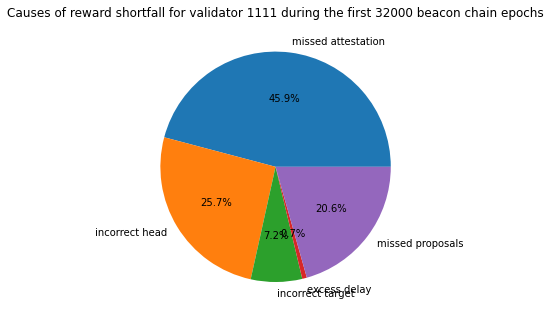

In [8]:
# get validator efficiency for validator 1111

cursor.execute(
    f"SELECT * FROM t_validator_epoch_extras WHERE f_validator_index = 1111 AND f_epoch = {END_EPOCH}"
)
_, _, _, att_reward, max_att_reward, missed, target, head, delay, prop_reward, missed_props = cursor.fetchone()

max_reward = max_att_reward + prop_reward + missed_props
actual_reward = att_reward + prop_reward

print(f"max reward: {max_reward/1e9:.4f} ETH")
print(f"actual reward: {actual_reward/1e9:.4f} ETH")
print(f"validator efficiency = {100*actual_reward/max_reward:.1f}%")
shortfall = max_reward - actual_reward
print(f"shortfall {shortfall/1e9:.4f} ETH")
print(f"...due to missed attestations: {missed/1e9:.4f} ETH ({100*missed/shortfall:.1f}%)")
print(f"...due to incorrect head:      {head/1e9:.4f} ETH ({100*head/shortfall:.1f}%)")
print(f"...due to incorrect target:    {target/1e9:.4f} ETH ({100*target/shortfall:.1f}%)")
print(f"...due to excess delay:        {delay/1e9:.4f} ETH ({100*delay/shortfall:.1f}%)")
print(f"...due to missed proposals:    {missed_props/1e9:.4f} ETH ({100*delay/shortfall:.1f}%)")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(
    [missed, head, target, delay, missed_props],
    labels=['missed attestation', 'incorrect head', 'incorrect target', 'excess delay', 'missed proposals'],
    autopct='%1.1f%%'
)
ax.set_title(
    f'Causes of reward shortfall for validator 1111 during the first {END_EPOCH} beacon chain epochs'
)
plt.show()

# Validator Comparisons

So we have identified that our example validator achieved a validator efficiency of about 98%. This implies that this validator is very close to receiving the maximum rewards available from the protocol. But how typical is this? To make a comparison, let's choose a large set of validators and take a look at the distribution of validator efficiency across the set.

For the longest possible comparison period, we'll choose the set of genesis validators who were still validating at epoch 32000 (i.e. they hadn't been slashed or made a voluntary exit). For simplicity we're also going to exclude the small number of validators who received slashing rewards, and those who received additional eth1 deposits. We can then calculate the valdator efficiency for each validator in the set and look at the distribution.

In [9]:
# identify a reduced validator set which excludes slashed validators, slashers and redeposit validators

FUTURE_EPOCH = 2**64 - 1 # from spec

cursor.execute(
    "SELECT f_index, f_activation_epoch, f_exit_epoch, f_slashed, f_public_key "
    "FROM t_validators ORDER BY f_index"
)

validators = [{
    'index': r[0],
    'activation_epoch': FUTURE_EPOCH if r[1] is None else r[1],
    'exit_epoch': FUTURE_EPOCH if r[2] is None else r[2],
    'slashed': r[3],
    'slasher': False,
    'redeposit': False,
    'pubkey': r[4].hex()
} for r in cursor.fetchall()]

pubkey_lookup = {v['pubkey']: v for v in validators}

# identify slashers

cursor.execute("SELECT f_inclusion_slot FROM t_proposer_slashings")
proposer_slashings = [s[0] for s in cursor.fetchall()]

cursor.execute("SELECT f_inclusion_slot FROM t_attester_slashings")
slashings = proposer_slashings + [s[0] for s in cursor.fetchall()]

for s in slashings:
    cursor.execute(f"SELECT f_validator_index FROM t_proposer_duties WHERE f_slot = {s}")
    validators[cursor.fetchone()[0]]["slasher"] = True
        
# check for any instances of validator deposits made to already active validators

cursor.execute("SELECT f_inclusion_slot, f_validator_pubkey FROM t_deposits")
for row in cursor.fetchall():
    deposit_slot = row[0]
    pubkey = row[1].hex()
    if pubkey not in pubkey_lookup:
        continue
    else:
        validator = pubkey_lookup[pubkey]
    
    if deposit_slot // 32 > validator["activation_epoch"] and deposit_slot // 32 < validator["exit_epoch"]:
        validator["redeposit"] = True

reduced_genesis_set = [
    v for v in validators if v["activation_epoch"] == 0 and not (
        v["slashed"] or v["slasher"] or v["redeposit"] or v["exit_epoch"] < END_EPOCH
    )
]

n_genesis = sum(1 for v in validators if v["activation_epoch"] == 0)
n_reduced = sum(1 for v in reduced_genesis_set if v["activation_epoch"] == 0)

print(f"validator count (genesis set): {n_genesis}")
print(f"validator count (reduced genesis set): {n_reduced} ({n_genesis - n_reduced} excluded)")

validator count (genesis set): 21063
validator count (reduced genesis set): 20993 (70 excluded)


validator efficiency statistics:

        minimum = -77.02%
 1st percentile = 73.49%
 lower quartile = 97.30%
         median = 98.61%
 upper quartile = 98.99%
99th percentile = 99.25%
        maximum = 99.43%


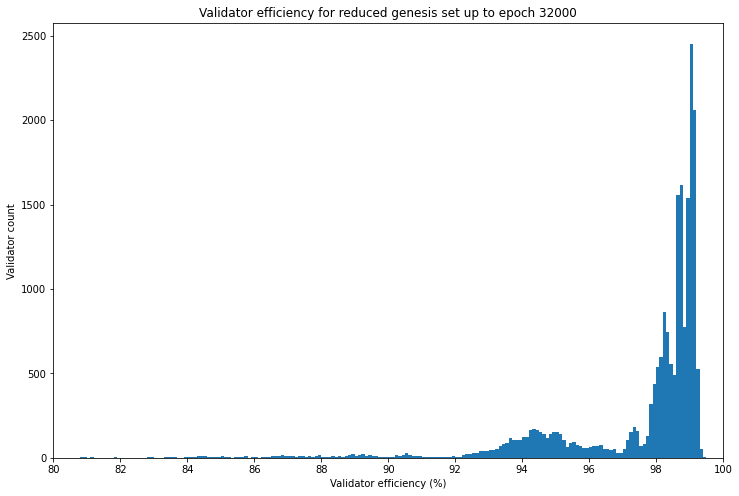

In [10]:
# calculate validator efficiencies for reduced genesis set

for v in reduced_genesis_set:
    cursor.execute(
        f"SELECT * FROM t_validator_epoch_extras "
        f"WHERE f_validator_index = {v['index']} AND f_epoch = {END_EPOCH}"
    )
    (
        _, _, _, 
        v['att_reward'],
        v['max_att_reward'],
        v['missed_att_shortfall'],
        v['incorrect_target_shortfall'],
        v['incorrect_head_shortfall'],
        v['excess_delay_shortfall'],
        v['proposer_reward'],
        v['missed_proposer_reward']
    ) = cursor.fetchone()
    
    max_reward = v['max_att_reward'] + v['proposer_reward'] + v['missed_proposer_reward']
    v['validator_efficiency'] = (v['att_reward'] + v['proposer_reward']) / max_reward

x = [100 * v['validator_efficiency'] for v in reduced_genesis_set if v['validator_efficiency']]
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(x, bins=[e / 10 for e in range(800,1000)])
ax.set_xlim(xmin=80, xmax=100)
ax.set_title(f'Validator efficiency for reduced genesis set up to epoch {END_EPOCH}')
ax.set_xlabel('Validator efficiency (%)')
ax.set_ylabel('Validator count')
ax.set_xticks(range(80,101,2))

quartiles = statistics.quantiles(x)
percentiles = statistics.quantiles(x, n=100)

print("validator efficiency statistics:\n")
print(f"        minimum = {min(x):.2f}%")
print(f" 1st percentile = {percentiles[0]:.2f}%")
print(f" lower quartile = {quartiles[0]:.2f}%")
print(f"         median = {quartiles[1]:.2f}%")
print(f" upper quartile = {quartiles[2]:.2f}%")
print(f"99th percentile = {percentiles[98]:.2f}%")
print(f"        maximum = {max(x):.2f}%")

So in fact our example validator 1111 with an efficiency of 97.7% sits somewhere in the lower half of validators by this metric, considering that the median validator efficiency is over 98%.

As shown in the histogram, the majority of validators cluster in the range 97% — 99%, with no validators achieving perfect (100%) efficiency. At the other end of the spectrum, a small number of validators actually have negative efficiency (i.e. their net reward over the period is negative). This includes the handful of validators which have never made a successful attestation, perhaps due to losing their validator keys or a misunderstanding of the technical steps required to validate successfully.

The histogram seems to show a bimodal distribution with most of the validators not in the 97% — 99% range instead grouping in the range 92% — 97%. Let's take a look at these two groups of validators to see if there's a clear cause for the difference in performance.

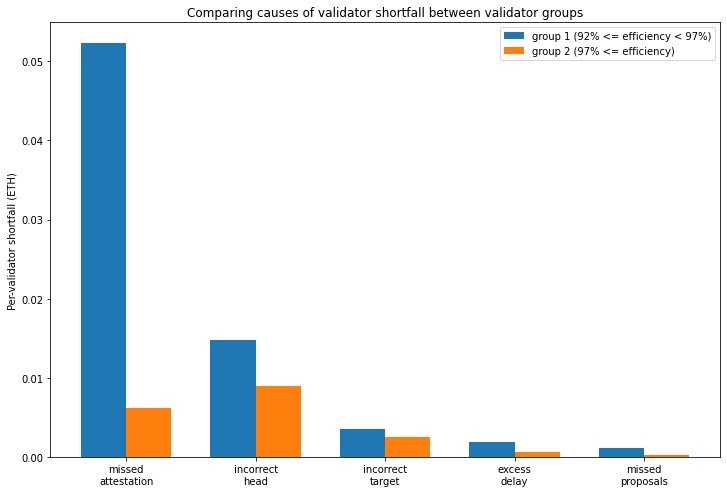

In [11]:
# show shortfall pie charts for the two validator groups 

group1_shortfalls = [0.0] * 5
group2_shortfalls = group1_shortfalls.copy()
group1_count = group2_count = 0

for v in reduced_genesis_set:
    if v['validator_efficiency'] >= 0.92 and v['validator_efficiency'] < 0.97:
        group1_shortfalls[0] += v['missed_att_shortfall']
        group1_shortfalls[1] += v['incorrect_head_shortfall']
        group1_shortfalls[2] += v['incorrect_target_shortfall']
        group1_shortfalls[3] += v['excess_delay_shortfall']
        group1_shortfalls[4] += v['missed_proposer_reward']
        group1_count += 1
    elif v['validator_efficiency'] >= 0.97:
        group2_shortfalls[0] += v['missed_att_shortfall']
        group2_shortfalls[1] += v['incorrect_head_shortfall']
        group2_shortfalls[2] += v['incorrect_target_shortfall']
        group2_shortfalls[3] += v['excess_delay_shortfall']
        group2_shortfalls[4] += v['missed_proposer_reward']
        group2_count += 1

labels = ['missed\nattestation', 'incorrect\nhead', 'incorrect\ntarget', 'excess\ndelay', 'missed\nproposals']
width = 0.35
x1 = [x - width/2 for x in range(len(labels))]
x2 = [x + width/2 for x in range(len(labels))]

y1 = [y / group1_count / 1e9 for y in group1_shortfalls]
y2 = [y / group2_count / 1e9 for y in group2_shortfalls]

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x1, y1, width, label='group 1 (92% <= efficiency < 97%)')
rects2 = ax.bar(x2, y2, width, label='group 2 (97% <= efficiency)')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('Per-validator shortfall (ETH)')
ax.set_title('Comparing causes of validator shortfall between validator groups')
ax.legend();

Comparing the two groups of validators, we see the lower-performing group (group 1) have a greater shortfall for each of the 5 causes. However, by a substantial margin it is the difference in the missed attestation shortfall which separates the two groups. This suggests that the cause is simply validator uptime. Although precisely why the validators would be split roughly 50-50 into two distinct distributions by validator uptime is unclear (perhaps a "hobbyist" versus "institution" divide?).

In [14]:
# write validator performance stats up to epoch 32000 to csv

with open('validator_performance.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(
        [
            'validator', 'efficiency', 'attestation_reward', 'max_attestation_reward', 
            'missed_attestation_shortfall', 'target_shortfall', 'head_shortfall', 
            'excess_delay_shortfall', 'proposer_reward', 'missed_proposer_reward','max_reward'
        ]
    )
    for v in validators:
        cursor.execute(
            f"SELECT * FROM t_validator_epoch_extras "
            f"WHERE f_validator_index = {v['index']} AND f_epoch = {END_EPOCH}"
        )
        
        result = cursor.fetchone()
        if result is None:
            continue
            
        (
            _, _, _, 
            att_reward,
            max_att_reward,
            missed_att_shortfall,
            target_shortfall,
            head_shortfall,
            excess_delay_shortfall,
            proposer_reward,
            missed_proposer_reward
        ) = result

        max_reward = max_att_reward + proposer_reward + missed_proposer_reward
        efficiency = (att_reward + proposer_reward) / max_reward

        writer.writerow(
            [
                v['index'], efficiency, att_reward, max_att_reward, missed_att_shortfall, target_shortfall,
                head_shortfall, excess_delay_shortfall, proposer_reward, missed_proposer_reward, max_reward
            ]
        )

For the details of individual validator performance, a [CSV file](validator_performance.csv) is available. This shows the validator efficiency for each validator over the first 32,000 epochs, and the shortfall break-down (in gwei).

# Conclusions
In this article we saw that our previous model for validator rewards was reasonably close to the rewards earned in practice. However, we delved into the details, we saw that a substatial proportion of the shortfall between what validators earned and what they *could have* earned was due to intricacies of the validator rewards scheme which were not included in the model.

Next we used a metric for validator performance — validator efficiency — which allowed us to make a fair comparison between validators. Applying this metric over the first 32,000 beacon chain epochs, we saw that most validators captured the vast majority of the rewards available to them — even the lowest-performing quartile managed a validator efficiency over 97%. This implies that for most validators, the opportunity to improve their rewards is quite limited. But, where validators are receiving substantially less than the maximum, the most likely explanation seems to be validator downtime. So most validators receiving substantially less than the maximum rewards should focus first on improving their uptime.